# AI applied to battery manufacturing

----------------------------------------
This notebook provides necessary resources for the application of _supervised_ Machine Learning regression approaches during the training session. The code below is an example of Python code for the tranining/testing, and provides a statistical comparison for the effect of hyperparameters tuning on the model performance.<br>
This notebook has not to be launched due to high computational time requested for the statistical comparison. Refer to the other notebook **training-yourcode.ipynb** to make your own training on another dataset, with the functions detailed below.

----------------------------------------

## Python libraries

All the libraries below are required for you to make use necessary functions, and make trials during the training session. Please refer to the GitHub for Python installations in the case you are not able to load properly the libraries.

In [246]:
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from skopt.space import Real, Integer
from IPython.display import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skopt import Optimizer
import pandas as pd
import numpy as np
import warnings
import random
import time

warnings.filterwarnings("ignore")

We set the dataset into the variable $X$. This variables contains the different input variables and output variables.

In [448]:
X = pd.read_csv("../resources/your_own_dataset.csv", sep=",")
X.head()

## Example of regression learnings

In our case study, we will see how to properly define a regression model to fit an electrode property as a function of input variables. We take the example of **Gradient Boosting Regression** from the family of _ensemble learnings_. The idea is to find the best GBR model (f):
<br><br>
<center>$ f: (X_1, X_2, X_3) \rightarrow Y $</center>

<br>
In this notebook, we will illustrates the capabilities of different approaches to fit the GBR model to increase predictive capabilities. We compare different approaches and validate the methodologies. For the training session, you will be able to apply such a methodology on another experimental dataset (follow the instructioons from the GitHub).

The size of the training/testing datasets impact the predictive capabilities of your model, due to some bias that may appear within the training dataset. This induces heterogenenous distributions of data that the model is unable to learn correctly when testing with unseen data. More precisely, setting hyperparameters values for those dataset decreases/increases the predictive capabilities.<br><br>
For our regression approach, we use the $R^2_{score}$ and the $Root Mean Square Error$ in percentage to validate the training and testing of the model.<br><br>

Example of the code to follow to train a regression model. We compare the **Linear Regression** model being the most common regression model, versus the GBR being more complexe.

In [449]:
column, ratio, simple = 'Y1', 0.80, False
Train, Test = train_test_split(X[['X1', 'X2', 'X3', column]], train_size=ratio)

XTrain = Train.drop(columns=column)
XTest = Test.drop(columns=column)
YTrain = Train[column]
YTest = Test[column]

print(XTrain.shape, YTrain.shape, XTest.shape, YTest.shape)

if simple:
    mod = LinearRegression()
else:
    mod = GradientBoostingRegressor()

mod.fit(XTrain, YTrain.values)

predictions = mod.predict(XTest)

print("R2 train: %.8f" % (r2_score(YTrain.values, mod.predict(XTrain))))
print("R2 test: %.8f" % (r2_score(YTest.values, predictions)))

Here an example of the distribution of the $R^2_{score}$ for 10 random train/test processes, as a function of the hyperparameters from the GBR model. The idea is to see that there may appear variabilities on the resulting predictive capabilities.

In [244]:
def train_model(estimators, learning_rate):

    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    
    r2_test = []
    for i in range(10):
        Train, Test = train_test_split(X[['X1', 'X2', 'X3', column]], train_size=0.5)
        XTrain = Train.drop(columns=column)
        XTest = Test.drop(columns=column)
        YTrain = Train[column]
        YTest = Test[column]
        mod = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate)   
        mod.fit(XTrain, YTrain.values)
        predictions = mod.predict(XTest)
        r2_test.append(r2_score(YTest.values, predictions))
        
    boxplotElements = plt.boxplot(r2_test, vert=True, sym='', whis=1.2, 
                                  widths=[0.35], positions=[1], patch_artist=True)
    for patch, c in zip(boxplotElements['boxes'], ["blue"]):
        patch.set_facecolor(c)
    for element in boxplotElements['medians']:
        element.set_color("black")
        element.set_linewidth(1.8)
    for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*2):
        element.set_color(c)
        element.set_linewidth(2.5)
        element.set_linewidth(2.5)
    for element, c in zip(boxplotElements['caps'], ["mediumblue"]*2):
        element.set_color(c)
        element.set_linewidth(2.5)

    plt.xlabel("("+str(estimators)+"; "+str(learning_rate)+")" , fontsize=20, fontweight="bold", labelpad=12)
    plt.ylabel("$R^2_{score}$", fontsize=20)
    plt.yticks(fontweight="bold", fontsize=15)
    plt.xticks([])
    plt.ylim(0.3, 1.05)
    plt.show()

This example deals with 2 different hyperparameters. You are free to modify them.

In [245]:
interact(train_model, estimators=(100, 1500, 10), learning_rate=(0.01, 0.05, 0.005))

interactive(children=(IntSlider(value=800, description='estimators', max=1500, min=100, step=10), FloatSlider(…

<function __main__.train_model(estimators, learning_rate)>

## GridSearchCV: optimize your learning process

A cross validation for the training dataset allows the model to better understand the distributions of data for subsets of your training dataset. It looks how a model predicts well new ouputs based on training for different subsets to check if the latter model is under/overfitting [[REF1](https://scikit-learn.org/stable/modules/grid_search.html)]. Our example below compare the predictive capabilities for the GBR to correctly train and test for two different approaches:
- using Hyperparameters tuning with GridSearchCV.
- using the default model provided by the library.

<br><br>
We define the set of hyperparameters and the name of the ouput variable within the dataset. Those parameters change if you use another regression model.

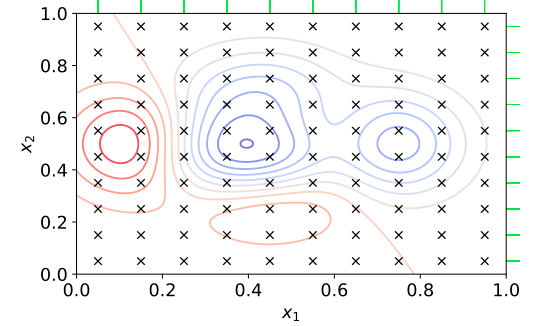

In [26]:
Image(filename="../resources/gridsearchcv.png")

In [307]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

We initialize a loop for train/test many times with a final purpose to apply a statistical comparison. Indeed, comparing the results for one single seed is uncorrect. For each of the 75 steps, we calculate the average validation metrics over 10 random training/testing datasets.<br> All relevant functions for training and calculating predictive capabilities com from the $scikit$-$learn$ library. The final results are stored inside a dataframe to save them.

In [356]:
## DO NOT LAUNCH THE CODE
validation = pd.DataFrame(columns=["R2", "R2_grid", "RMSE", "RMSE_grid", "Time", "Time_grid"])

for nb_steps in range(75):
    
    r2_score_grid, r2_score_ = [], []
    rmse_grid, rmse = [], []
    timer_grid, timer = [], []
    
    for i in range(10):
        
        #define the training and testing dataset with the inputs and outputs variables
        Train, Test = train_test_split(X[['X1', 'X2', 'X3', column]], train_size=0.8)
        XTrain = Train.drop(columns=column)
        XTest = Test.drop(columns=column)
        YTrain = Train[column]
        YTest = Test[column]
        
        #########################################################
        #GridSearchCV
        #########################################################
        start_time = time.time()
        mod = GradientBoostingRegressor()
        mod = GridSearchCV(estimator=mod, param_grid = parameters, cv = 2, n_jobs=-1)           
        mod.fit(XTrain, YTrain.values)

        predictions = mod.predict(XTest)
        r2_score_grid.append(r2_score(YTest.values, predictions))
        rmse_grid.append(np.sqrt(np.mean(np.square([(i-j)/i for i,j in zip(YTest.values,
                                                                           predictions)]))) * 100)
        timer_grid.append(time.time() - start_time)
        
        
        #########################################################
        #Default
        #########################################################
        start_time = time.time()
        mod = GradientBoostingRegressor()          
        mod.fit(XTrain, YTrain.values)

        predictions = mod.predict(XTest)
        r2_score_.append(r2_score(YTest.values, predictions))
        rmse.append(np.sqrt(np.mean(np.square([(i-j)/i for i,j in zip(YTest.values,
                                                                           predictions)]))) * 100)
        timer.append(time.time() - start_time)
        
    #incrementation of the results inside the dataframe
    validation.loc[len(validation)] = [np.mean(r2_score_), np.mean(r2_score_grid), np.mean(rmse),
                                       np.mean(rmse_grid), np.mean(timer), np.mean(timer_grid)]
        
    print(">interation n°%d" % (nb_steps + 1))

We perform a comparison of distributions for the 2 validation metrics. We use the $boxplot$ function available under $matplotlib$ to draw the different distributions.

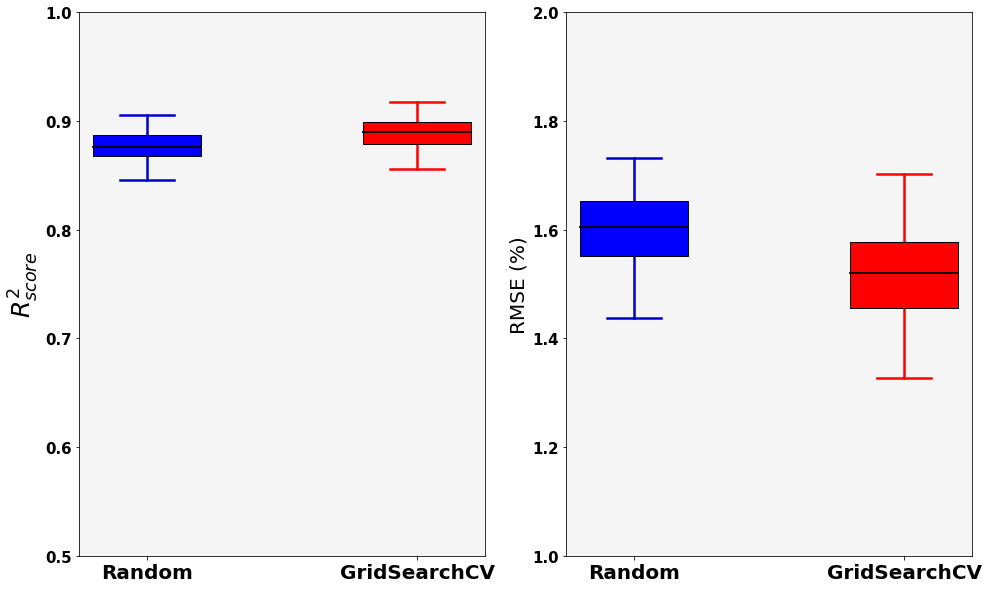

In [105]:
## DO NOT LAUNCH THE CODE
fig=plt.figure(figsize=(16,10))
plt.subplot(121)
ax = plt.gca()
ax.set_facecolor('whitesmoke')

#matplotlib function for the boxplot
boxplotElements = plt.boxplot(np.array(validation)[:, [0,1]], vert=True, sym='', whis=1.2, widths=[0.8]*2,
                                                          positions=[1,3], patch_artist=True)

#tools for designing a nice plot
for patch, c in zip(boxplotElements['boxes'], ["blue"]+["red"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("$R^2_{score}$", fontsize=25)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3], ["Random", "GridSearchCV"], fontsize=20, fontweight="bold")
plt.ylim(0.5, 1)

plt.subplot(122)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
boxplotElements = plt.boxplot(np.array(validation)[:, [2,3]], vert=True, sym='', whis=1.2, widths=[0.8]*2,
                                                          positions=[1,3], patch_artist=True)
for patch, c in zip(boxplotElements['boxes'], ["blue"]+["red"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("RMSE (%)", fontsize=20)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3], ["Random", "GridSearchCV"], fontsize=20, fontweight="bold")
_=plt.ylim(1, 2)

Even if we observe very close distributions, we would validate this differences by using a statistical test. In this case, we apply a $paired$ $Student$ test since we previously know the variables are following a normal distribution.
- $R^2_{score}$

In [115]:
test = True
for col in range(2):
    
    #test if the distributions follow a Gaussian distribution.
    if stats.shapiro(np.array(validation)[:, col])[1] <= 0.05:
        test = False
#apply the good test
if test:
    print("p.value: " + str(stats.ttest_rel(np.array(validation)[:, 0], np.array(validation)[:, 1])[1]))

p.value: 1.3697998757895502e-14


- $RMSE (\%)$

In [116]:
test = True
for col in range(2, 4):
    if stats.shapiro(np.array(validation)[:, col])[1] <= 0.05:
        test = False
if test:
    print("p.value: " + str(stats.ttest_rel(np.array(validation)[:, 2], np.array(validation)[:, 3])[1]))

p.value: 1.8413168286957504e-17


We calculate the confidence interval (CI) for the distribution displayed above. The latter interval provides more statistical analytics on the capabilities of the GBR algorithm to train/test regardless the seed of the re-sampling procedure. It shows how precise a GBR model is likely to be.<br><br>
You can see the CI are very closed between each other, even if we observe a significant difference.

In [169]:
print(stats.t.interval(0.95, len(validation)-1, loc=np.mean(np.array(validation)[:, 1]),
                                                            scale=stats.sem(np.array(validation)[:, 1])))

(0.8841373488081515, 0.8915196839908107)


In [170]:
print(stats.t.interval(0.95, len(validation)-1, loc=np.mean(np.array(validation)[:, 0]),
                                                            scale=stats.sem(np.array(validation)[:, 0])))

(0.8734988643593604, 0.8807639308046336)


**Conclusions**: we show how to train a GBR regression model for two different types of approaches.
- the GridSearCV is significantly better compared to the default functions provided by the package.
- even if we observe few variabilities in validation metrics, the differences are important especially in the case of electrode properties where those values are tricky to obtain due to the uncertaintity from the measurements.
- the apporach can be transposed to any type of regression model from scikit-learn.

## Bayesian optimization: maximize the predictive capabilities

The Bayesian Optimization (BO) framework is well known for dealing with optimization problems with probabilistic components. It is already famous within the battery litterature in order to for instance, maximize the lifetime for a cell, or minimizing the error between experimental results and its corresponding modeling.<br><br>
The idea of BO is to minimize an objective function by finding the best set of values which minimize such a function:<br><br>

<center>$ \mathbf{x}^* \hspace{0.1cm} = \hspace{0.1cm} argmin_x \hspace{0.09cm}(C_f(x)) $</center>

<br><br>
**How to apply the BO framework to our regression fitting ?**
<br>
The idea of the GridSearchCV was to find the best set of hyperparameters to maximize the validation metrics. As a consequence, this means we are able to minimize the error between predictions from the model and real outputs by searching the best hyperparameters: 
- $x \rightarrow$ hyperparameters.
- $C_f(x) \rightarrow $ validation metric after training a GBR model with a set of hyperparameters.

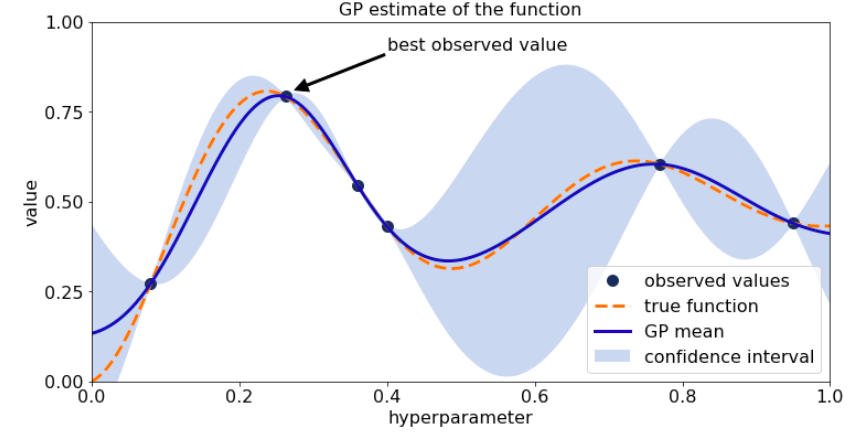

In [6]:
Image(filename="../resources/bayesian-optimization.png")

Here an example:

In [ ]:
Train, Test = train_test_split(X[['X1', 'X2', 'X3', column]], train_size=0.8)
XTrain = Train.drop(columns=column)
XTest = Test.drop(columns=column)
YTrain = Train[column]
YTest = Test[column]

In [ ]:
opt = Optimizer([Real(0.001, 0.05), Real(0.05, 0.95), Integer(20, 1500), Integer(2, 10)], "GP",
                acq_func="gp_hedge", acq_optimizer="sampling",initial_point_generator="random")

In [ ]:
for nb_step in range(100):

    #ask BO to test with a specific set of hyperparameters
    next_x = opt.ask()  
    
    #train the corresponding GBR model
    mod = GradientBoostingRegressor(learning_rate=next_x[0], subsample=next_x[1], n_estimators=next_x[2],
                                   max_depth=next_x[3])          
    mod.fit(XTrain, YTrain.values)
    
    #predict and calculate the error
    predictions = mod.predict(XTest)
    cost = 1 - r2_score(YTest.values, predictions)
    
    opt.tell(next_x, cost)
    
    print(">%d, fopt=%.4f, x1=%.4f, x2=%.4f, x3=%.4f, x4=%4f" % (nb_step+1, opt.get_result().fun, next_x[0],
                                                 next_x[1], next_x[2], next_x[3]))

As we did for the _GridSearchCV_, we calculate the distributions of validation metrics.

In [25]:
## DO NOT LAUNCH THE CODE
validation_bo = pd.DataFrame(columns=["R2", "R2_grid", "RMSE", "RMSE_grid", "Time", "Time_grid"])

for nb_steps in range(75-13):
    
    r2_score_grid, r2_score_ = [], []
    rmse_grid, rmse = [], []
    timer_grid, timer = [], []
    
    for i in range(10):
        
        Train, Test = train_test_split(X[['X1', 'X2', 'X3', column]], train_size=0.8)
        XTrain = Train.drop(columns=column)
        XTest = Test.drop(columns=column)
        YTrain = Train[column]
        YTest = Test[column]
        
        #########################################################
        #Bayesian optimization
        #########################################################
        start_time = time.time()
        
        opt = Optimizer([Real(0.001, 0.05), Real(0.05, 0.95), Integer(20, 1500), Integer(2, 10)], "GP",
                acq_func="gp_hedge", acq_optimizer="sampling",initial_point_generator="random")
        for nb_step in range(100):

            next_x = opt.ask()    
            mod = GradientBoostingRegressor(learning_rate=next_x[0], subsample=next_x[1], n_estimators=next_x[2],
                                           max_depth=next_x[3])          
            mod.fit(XTrain, YTrain.values)
            predictions = mod.predict(XTest)
            cost = 1 - r2_score(YTest.values, predictions)
            if nb_step > 0:
                if cost < opt.get_result().fun:
                    best_estimator = mod

            opt.tell(next_x, cost)
            
        predictions = best_estimator.predict(XTest)
        r2_score_grid.append(r2_score(YTest.values, predictions))
        rmse_grid.append(np.sqrt(np.mean(np.square([(i-j)/i for i,j in zip(YTest.values,
                                                                           predictions)]))) * 100)
        timer_grid.append(time.time() - start_time)
        
        #########################################################
        #Default
        #########################################################
        start_time = time.time()
        mod = GradientBoostingRegressor()          
        mod.fit(XTrain, YTrain.values)

        predictions = mod.predict(XTest)
        r2_score_.append(r2_score(YTest.values, predictions))
        rmse.append(np.sqrt(np.mean(np.square([(i-j)/i for i,j in zip(YTest.values,
                                                                           predictions)]))) * 100)
        timer.append(time.time() - start_time)
     
    #incrementation of the results inside the dataframe
    validation_bo.loc[len(validation_bo)] = [np.mean(r2_score_), np.mean(r2_score_grid), np.mean(rmse),
                                       np.mean(rmse_grid), np.mean(timer), np.mean(timer_grid)] 
        
    print(">interation n°%d" % (nb_steps + 1))

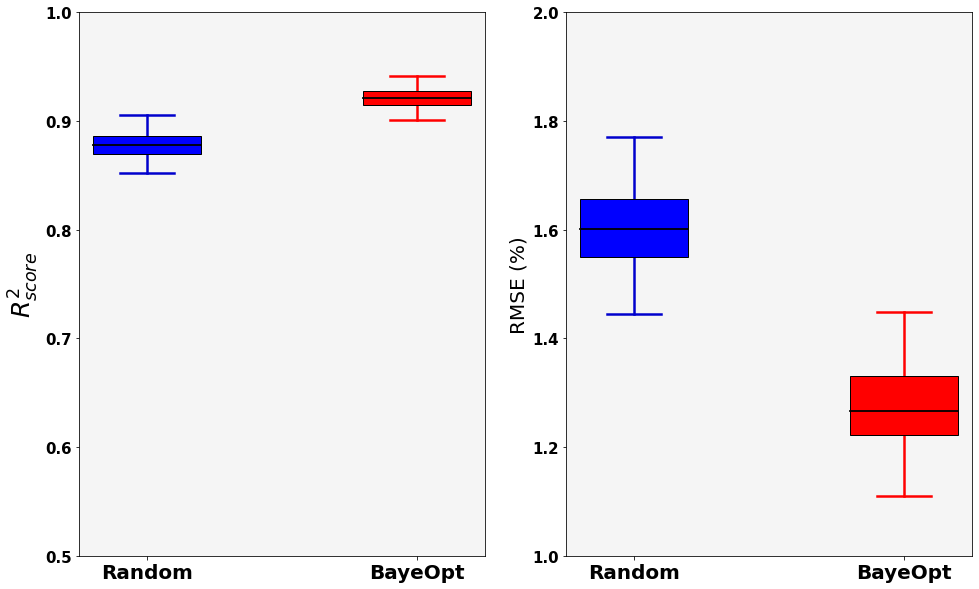

In [13]:
## DO NOT LAUNCH THE CODE
fig=plt.figure(figsize=(16,10))
plt.subplot(121)
ax = plt.gca()
ax.set_facecolor('whitesmoke')

#matplotlib function for the boxplot
boxplotElements = plt.boxplot(np.array(validation_bo)[:, [0,1]], vert=True, sym='', whis=1.2, widths=[0.8]*2,
                                                          positions=[1,3], patch_artist=True)

#tools for designing a nice plot
for patch, c in zip(boxplotElements['boxes'], ["blue"]+["red"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("$R^2_{score}$", fontsize=25)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3], ["Random", "BayeOpt"], fontsize=20, fontweight="bold")
plt.ylim(0.5, 1)

plt.subplot(122)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
boxplotElements = plt.boxplot(np.array(validation_bo)[:, [2,3]], vert=True, sym='', whis=1.2, widths=[0.8]*2,
                                                          positions=[1,3], patch_artist=True)
for patch, c in zip(boxplotElements['boxes'], ["blue"]+["red"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*2+["red"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("RMSE (%)", fontsize=20)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3], ["Random", "BayeOpt"], fontsize=20, fontweight="bold")
_=plt.ylim(1, 2)

- $R^2_{score}$

In [15]:
test = True
for col in range(2):
    
    #test if the distributions follow a Gaussian distribution.
    if stats.shapiro(np.array(validation_bo)[:, col])[1] <= 0.05:
        test = False
#apply the good test
if test:
    print("p.value: " + str(stats.ttest_rel(np.array(validation_bo)[:, 0], np.array(validation_bo)[:, 1])[1]))

p.value: 6.669623765330659e-58


- $RMSE (\%)$

In [16]:
test = True
for col in range(2, 4):
    if stats.shapiro(np.array(validation_bo)[:, col])[1] <= 0.05:
        test = False

if test:
    print("p.value: " + str(stats.ttest_rel(np.array(validation_bo)[:, 0], np.array(validation_bo)[:, 1])[1]))

p.value: 6.669623765330659e-58


## Comparisons of regression learning processes

At the end, we can compare the overall distributions of validations metrics, as a function of the method applied for the training step. You have the choice for the selection of the hyperparameters tuning, from the most simple one to the hardest one.

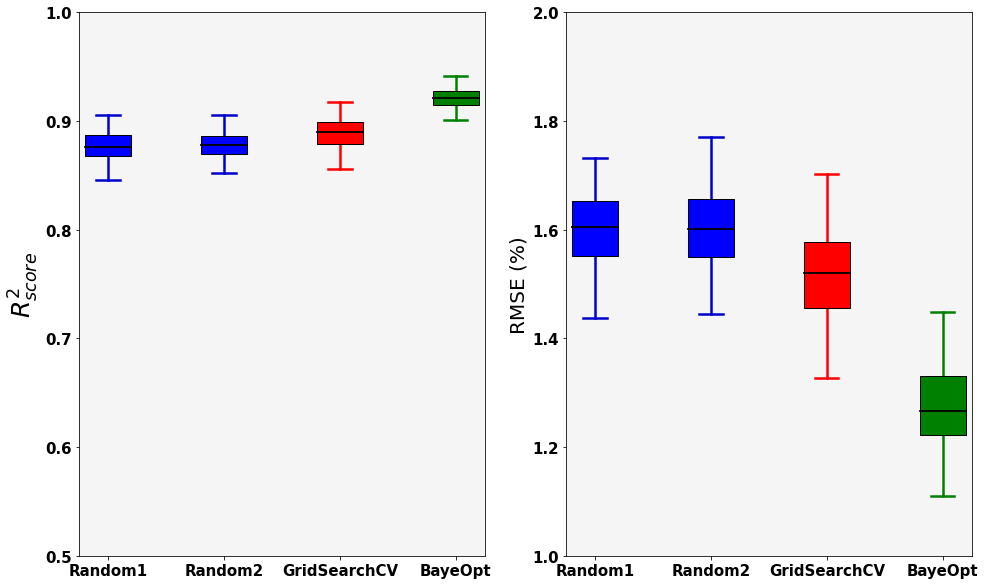

In [21]:
## DO NOT LAUNCH THE CODE
fig=plt.figure(figsize=(16,10))
plt.subplot(121)
ax = plt.gca()
ax.set_facecolor('whitesmoke')

#matplotlib function for the boxplot
boxplotElements = plt.boxplot([validation.iloc[:, 0], validation_bo.iloc[:, 0], validation.iloc[:, 1],
                               validation_bo.iloc[:, 1]], vert=True, sym='', whis=1.2,
                              widths=[0.8]*4, positions=[1,3,5,7], patch_artist=True)

#tools for designing a nice plot
for patch, c in zip(boxplotElements['boxes'], ["blue"]*2+["red"]+["green"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*4+["red"]*2+["green"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*4+["red"]*2+["green"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("$R^2_{score}$", fontsize=25)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3,5,7], ["Random1", "Random2", "GridSearchCV", "BayeOpt"], fontsize=15, fontweight="bold")
plt.ylim(0.5, 1)

plt.subplot(122)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
boxplotElements = plt.boxplot([validation.iloc[:, 2], validation_bo.iloc[:, 2], validation.iloc[:, 3],
                               validation_bo.iloc[:, 3]], vert=True, sym='', whis=1.2,
                              widths=[0.8]*4, positions=[1,3,5,7], patch_artist=True)
for patch, c in zip(boxplotElements['boxes'], ["blue"]*2+["red"]+["green"]):
    patch.set_facecolor(c)
for element in boxplotElements['medians']:
    element.set_color("black")
    element.set_linewidth(1.8)
for element, c in zip(boxplotElements['whiskers'], ["mediumblue"]*4+["red"]*2+["green"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
    element.set_linewidth(2.5)
for element, c in zip(boxplotElements['caps'], ["mediumblue"]*4+["red"]*2+["green"]*2):
    element.set_color(c)
    element.set_linewidth(2.5)
plt.ylabel("RMSE (%)", fontsize=20)
plt.yticks(fontweight="bold", fontsize=15)
plt.xticks([1,3,5,7], ["Random1", "Random2", "GridSearchCV", "BayeOpt"], fontsize=15, fontweight="bold")
_=plt.ylim(1, 2)